In [ ]:
# Core libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn for data splitting and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    accuracy_score, confusion_matrix, roc_curve, auc
)

# TensorFlow and Keras for building and training the deep learning model
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras import mixed_precision

# KaggleHub for downloading datasets
import kagglehub


This cell sets up all the required libraries for data handling, model creation, training, and evaluation.

This block downloads, processes, and splits the dataset while also offering a preview of sample training images.

Evaluates the trained model on unseen data and visualizes its performance with a confusion matrix.

In [ ]:
# Download both datasets from Kaggle using kagglehub
path1 = kagglehub.dataset_download("cdeotte/jpeg-isic2019-512x512")  # ISIC 2019
path2 = kagglehub.dataset_download("nodoubttome/skin-cancer9-classesisic")  # 9-Class ISIC

# Confirm dataset paths
print("Path to first dataset:", path1)
print("Path to second dataset:", path2)

# Downloads two separate skin cancer datasets — one with binary labels (benign/malignant) and another with 9 detailed diagnostic classes.

def load_and_combine_datasets(path1, path2):
    # Load and preprocess ISIC 2019 dataset
    df1 = pd.read_csv(os.path.join(path1, 'train.csv'))
    df1['path'] = df1['image_name'].apply(lambda x: os.path.join(path1, 'train', x + '.jpg'))
    df1['label'] = df1['benign_malignant'].apply(lambda x: 'malignant' if x == 'malignant' else 'benign')

    #Prepares the first dataset by attaching image paths and mapping labels to "benign" or "malignant".

    # Define the path to the second dataset
    base_dir = os.path.join(path2, 'Skin cancer ISIC The International Skin Imaging Collaboration')

    # Label groups for the second dataset
    malignant_classes = ['basal cell carcinoma', 'melanoma', 'squamous cell carcinoma']
    benign_classes = ['actinic keratosis', 'dermatofibroma', 'nevus',
                     'pigmented benign keratosis', 'seborrheic keratosis',
                     'vascular lesion']

    #Defines which of the 9 classes in the second dataset are considered benign vs. malignant.

    # Create empty lists to store paths and labels
    paths = []
    labels = []

    # Process both Train and Test folders
    for split in ['Train', 'Test']:
        split_dir = os.path.join(base_dir, split)
        if os.path.exists(split_dir):
            for class_name in os.listdir(split_dir):
                class_dir = os.path.join(split_dir, class_name)
                if os.path.isdir(class_dir):
                    for img_name in os.listdir(class_dir):
                        if img_name.endswith(('.jpg', '.jpeg', '.png')):
                            img_path = os.path.join(class_dir, img_name)
                            paths.append(img_path)
                            # Assign binary label based on class
                            if class_name.lower() in [c.lower() for c in malignant_classes]:
                                labels.append('malignant')
                            else:
                                labels.append('benign')

    # Walks through every class folder in both train/test splits of dataset 2, collecting image paths and assigning a binary label.

    # Create DataFrame for second dataset
    df2 = pd.DataFrame({
        'path': paths,
        'label': labels
    })

    # Combine datasets
    combined_df = pd.concat([df1, df2], ignore_index=True)

    # Converts the second dataset into a dataframe and merges it with the first one.

    # Print class distribution
    print("\nClass distribution in combined dataset:")
    print(combined_df['label'].value_counts())

    # Split into train and test sets
    train_df, test_df = train_test_split(
        combined_df,
        test_size=0.2,
        random_state=42,
        stratify=combined_df['label']
    )

    return train_df, test_df

    # Performs an 80/20 split on the full combined dataset while keeping the benign/malignant ratio consistent.

# Call the function to load and combine the datasets
train_df, test_df = load_and_combine_datasets(path1, path2)

# Print out basic statistics and class distribution
print("\nDataset Statistics:")
print(f"Total training samples: {len(train_df)}")
print(f"Total test samples: {len(test_df)}")
print("\nClass distribution in training set:")
print(train_df['label'].value_counts())
print("\nClass distribution in test set:")
print(test_df['label'].value_counts())

# Prints out how many samples are in each set and how balanced the labels are after merging.

# Verify if any file paths are broken
print("\nVerifying file paths...")
missing_files = []
for idx, row in train_df.iterrows():
    if not os.path.exists(row['path']):
        missing_files.append(row['path'])
for idx, row in test_df.iterrows():
    if not os.path.exists(row['path']):
        missing_files.append(row['path'])

if missing_files:
    print(f"\nWarning: Found {len(missing_files)} missing files")
    print("First few missing files:")
    for path in missing_files[:5]:
        print(path)
else:
    print("All file paths exist!")

#Ensures all the image files exist and flags any broken or missing paths.

Path to first dataset: /kaggle/input/jpeg-isic2019-512x512
Path to second dataset: /kaggle/input/skin-cancer9-classesisic

Class distribution in combined dataset:
label
benign       22123
malignant     5565
Name: count, dtype: int64

Dataset Statistics:
Total training samples: 22150
Total test samples: 5538

Class distribution in training set:
label
benign       17698
malignant     4452
Name: count, dtype: int64

Class distribution in test set:
label
benign       4425
malignant    1113
Name: count, dtype: int64

Verifying file paths...
All file paths exist!


Overall Accuracy (0.823 or 82.3%):
Good overall accuracy, but needs context with other metrics
Similar to our training accuracy (~0.825)
Class-wise Performance:
For Benign Cases:
Precision: 0.82
Recall: 0.99
F1-score: 0.90
Support: 4425 cases (80% of dataset)
Very good at identifying benign cases (99% recall)
For Malignant Cases:
Precision: 0.84
Recall: 0.14
F1-score: 0.25
Support: 1113 cases (20% of dataset)
Major issue: Only detecting 14% of malignant cases
Key Issues:
Very low recall for malignant cases (0.145) - this is critical
High class imbalance (4425 benign vs 1113 malignant)
Model is biased towards predicting benign

We could try:
Increasing class weights for malignant cases
Finding optimal threshold
Implementing stronger data augmentation

In [ ]:
def create_balanced_generators(train_df, test_df, batch_size=512):
    """Create balanced generators for training and validation."""

    # Ensure both classes are present
    if train_df['label'].nunique() != 2:
        raise ValueError("Training data must contain both classes (benign and malignant)")

    # Separate training data by class
    train_benign = train_df[train_df['label'] == 'benign'].copy()
    train_malignant = train_df[train_df['label'] == 'malignant'].copy()

    # Confirm each class has at least one sample
    if len(train_benign) == 0 or len(train_malignant) == 0:
        raise ValueError("Both classes must be present in training data")

    # Splits the training set into benign and malignant samples to apply tailored augmentation and enable balanced training.

    # Generator for benign samples with moderate augmentation
    train_benign_gen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=[0.7, 1.3],
        zoom_range=[0.8, 1.2],
        shear_range=0.2,
        fill_mode='nearest'
    ).flow_from_dataframe(
        train_benign,
        x_col='path',
        y_col='label',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='raw',
        shuffle=True
    )

    # Creates a generator for benign images with moderate augmentation to enhance generalization.

    # Generator for malignant samples with stronger augmentation
    train_malignant_gen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=45,
        width_shift_range=0.3,
        height_shift_range=0.3,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=[0.6, 1.4],
        zoom_range=[0.7, 1.3],
        shear_range=0.3,
        fill_mode='nearest'
    ).flow_from_dataframe(
        train_malignant,
        x_col='path',
        y_col='label',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='raw',
        shuffle=True
    )

    # Applies heavier augmentation to malignant samples to synthetically expand rare class diversity.

    # Create validation generator
    val_gen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
        test_df,
        x_col='path',
        y_col='label',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='binary',  # Keep binary for validation
        shuffle=False
    )

    return train_benign_gen, train_malignant_gen, val_gen

    # Creates a straightforward, unaugmented generator for the validation set.

def combined_generator(benign_gen, malignant_gen, malignant_weight=4.0):
    """Combine benign and malignant generators to create balanced batches with class weighting."""
    while True:
        # Get one batch from each generator
        benign_batch = next(benign_gen)
        malignant_batch = next(malignant_gen)

        # Combine the batches
        x = np.concatenate([benign_batch[0], malignant_batch[0]])

        # Create binary labels (0 for benign, 1 for malignant)
        benign_labels = np.zeros((benign_batch[0].shape[0], 1))
        malignant_labels = np.ones((malignant_batch[0].shape[0], 1))
        y = np.concatenate([benign_labels, malignant_labels])

        # Weight malignant samples more heavily
        sample_weights = np.concatenate([
            np.ones(benign_batch[0].shape[0]),  # Weight 1 for benign
            np.ones(malignant_batch[0].shape[0]) * malignant_weight  # Weight 4 for malignant
        ])

        # Shuffle the combined batch
        indices = np.arange(x.shape[0])
        np.random.shuffle(indices)
        x = x[indices]
        y = y[indices]
        sample_weights = sample_weights[indices]

        yield x, y, sample_weights

        # Dynamically mixes benign and malignant samples with oversampling via weighting — important for countering imbalance during training.

def create_model(input_shape=(224, 224, 3)):
    """Create NASNet-based model with custom classification layers."""

    # Load NASNetMobile with pretrained ImageNet weights (transfer learning)
    # - 'include_top=False' removes the original dense layers used for ImageNet classification
    # - This sets up a strong feature extractor for general-purpose images
    base_model = NASNetMobile(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the convolutional base so its pretrained weights are not updated during training
    # This helps retain the valuable generic features and reduces risk of overfitting
    base_model.trainable = False

    # Start building the custom head for binary classification

    # Apply global average pooling to reduce the feature maps into a 1D vector
    # This is more efficient and less prone to overfitting than flattening
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # Add a dense (fully connected) layer with ReLU activation
    # This allows the model to learn high-level patterns specific to our dataset
    x = Dense(512, activation='relu')(x)

    # Add dropout to prevent overfitting by randomly disabling 50% of neurons during training
    x = Dropout(0.5)(x)

    # Final output layer with sigmoid activation for binary classification
    # - Outputs a probability between 0 and 1 (e.g., 0.93 = high confidence of "malignant")
    predictions = Dense(1, activation='sigmoid', dtype='float32')(x)

    # Combine base model input and new classification head into a complete model
    return Model(inputs=base_model.input, outputs=predictions)

# Builds a compact, high-performing model using NASNetMobile with transfer learning and custom classification layers.

def find_optimal_threshold(model, test_gen, thresholds=np.arange(0.1, 0.9, 0.01)):
    """Find the optimal threshold that maximizes F1 score."""
    # Get predictions for all test data
    y_pred_probs = model.predict(test_gen)
    y_true = test_gen.labels

    best_threshold = 0.5
    best_recall = 0

    # Try different thresholds
    for threshold in thresholds:
      y_pred = (y_pred_probs > threshold).astype(int)
      recall = recall_score(y_true, y_pred)
      if recall > best_recall:
        best_recall = recall
        best_threshold = threshold

    return best_threshold, best_recall

def plot_metrics(model, test_gen, threshold=0.5):
    """Plot confusion matrix and ROC curve."""
    y_pred_probs = model.predict(test_gen)
    y_pred = (y_pred_probs > threshold).astype(int)
    y_true = test_gen.labels

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
    roc_auc = auc(fpr, tpr)

    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")

    plt.tight_layout()
    plt.show()

    # This function offers a full visual diagnostic of the model's classification behavior at a given threshold.

def focal_loss(gamma=2., alpha=.25):
    """
    Focal Loss for binary classification.

    Parameters:
    gamma: focusing parameter (default: 2.0)
    alpha: weighting factor in range (0,1) to balance positive vs negative examples (default: 0.25)
    """
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

        # Clip predictions to prevent log(0)
        epsilon = K.epsilon()
        pt_1 = K.clip(pt_1, epsilon, 1. - epsilon)
        pt_0 = K.clip(pt_0, epsilon, 1. - epsilon)

        # Calculate focal loss
        loss = -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - \
               K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))

        return loss

    return focal_loss_fixed

In [ ]:
# Create the class-balanced training and test generators
# - Returns separate benign and malignant generators for training
# - Test generator is standard (used for validation during training)

mixed_precision.set_global_policy('mixed_float16')
batch_size = 512
train_benign_gen, train_malignant_gen, test_gen = create_balanced_generators(
    train_df, test_df, batch_size
)

# This sets up augmented data generators for each class separately, allowing us to manually balance them later.

# Combine the two generators into a single one
# - Mixes benign and malignant samples per batch
# - Applies a higher weight to malignant examples (malignant_weight = 4.0)
train_gen = combined_generator(train_benign_gen, train_malignant_gen, malignant_weight=4.0)

# This ensures each training batch is balanced and that malignant cases are given higher importance via sample weights.

# Create the NASNet-based transfer learning model
model = create_model()

# Compile the model with:
# - Adam optimizer
# - Binary crossentropy (for 2-class output)
# - Evaluation metrics: accuracy, precision, recall
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=focal_loss(gamma=2.0, alpha=0.25),
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# The model is now ready to train on binary labels with metrics that reflect performance on imbalanced data.

# Define callbacks
callbacks = [
    # Stop training early if validation recall stops improving
    EarlyStopping(
        monitor='val_recall',
        patience=5,
        mode='max',
        restore_best_weights=True
    ),

    # Reduce learning rate when the model stops improving
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6
    ),

    # Save the model with the highest validation recall
    ModelCheckpoint(
        'best_nas_model.h5',
        monitor='val_recall',
        save_best_only=True,
        mode='max'
    )
]

# These callbacks help the model train efficiently, avoid overfitting, and prioritize recall — which is important in medical tasks to minimize false negatives (i.e., missing malignant cases).

# Steps per epoch = smallest of the two class generators
# Ensures balanced training without one class dominating
steps_per_epoch = min(len(train_benign_gen), len(train_malignant_gen))

# This limits training batches so that both classes contribute equally every epoch.

# Train the model
print("\nStarting model training...")
history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=30,
    validation_data=test_gen,
    callbacks=callbacks
)

# Begins training using a balanced, weighted dataset while monitoring validation recall and saving the best-performing model.


Found 17698 validated image filenames.
Found 4452 validated image filenames.
Found 5538 validated image filenames belonging to 2 classes.

Starting model training...
Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - accuracy: 0.5146 - loss: 0.6372 - precision: 0.5190 - recall: 0.3495 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9/9 ━━━━━━━━━━━━━━━━━━━━ 376s 35s/step - accuracy: 0.5167 - loss: 0.6246 - precision: 0.5209 - recall: 0.3538 - val_accuracy: 0.7990 - val_loss: 0.0621 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.5170 - loss: 0.2767 - precision: 0.8398 - recall: 0.0597 

9/9 ━━━━━━━━━━━━━━━━━━━━ 144s 18s/step - accuracy: 0.5201 - loss: 0.2729 - precision: 0.8186 - recall: 0.0735 - val_accuracy: 0.7212 - val_loss: 0.0886 - val_precision: 0.3486 - val_recall: 0.4456 - learning_rate: 0.0010
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 152s 19s/step - accuracy: 0.6155 - loss: 0.1896 - precision: 0.6615 - recall: 0.4818 - val_accuracy: 0.7999 - val_loss: 0.0463 - val_precision: 0.8571 - val_recall: 0.0054 - learning_rate: 0.0010
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 190s 24s/step - accuracy: 0.5169 - loss: 0.1735 - precision: 0.9029 - recall: 0.0424 - val_accuracy: 0.8100 - val_loss: 0.0552 - val_precision: 0.7194 - val_recall: 0.0898 - learning_rate: 0.0010
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 110s 14s/step - accuracy: 0.5951 - loss: 0.1623 - precision: 0.8213 - recall: 0.2397 - val_accuracy: 0.8084 - val_loss: 0.0505 - val_precision: 0.7549 - val_recall: 0.0692 - learning_rate: 0.0010
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 150s 19s/step - accuracy: 0.5685 - loss: 0.1581


Finding optimal classification threshold...
11/11 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step
Optimal threshold: 0.100
Best F1 score: 1.000

Plotting evaluation metrics...
11/11 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step


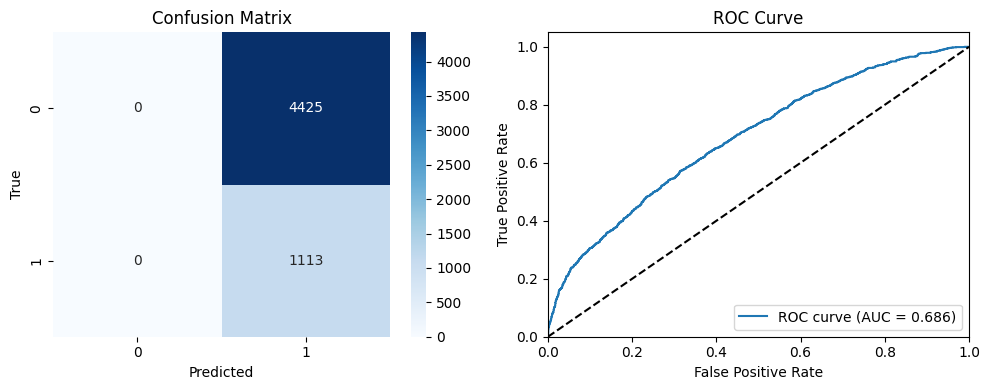

In [ ]:
# Find optimal threshold and evaluate model
print("\nFinding optimal classification threshold...")
optimal_threshold, best_f1 = find_optimal_threshold(model, test_gen)
print(f"Optimal threshold: {optimal_threshold:.3f}")
print(f"Best F1 score: {best_f1:.3f}")

# Plot metrics using the optimal threshold
print("\nPlotting evaluation metrics...")
plot_metrics(model, test_gen, threshold=optimal_threshold)

KeyError: 'recall_3'

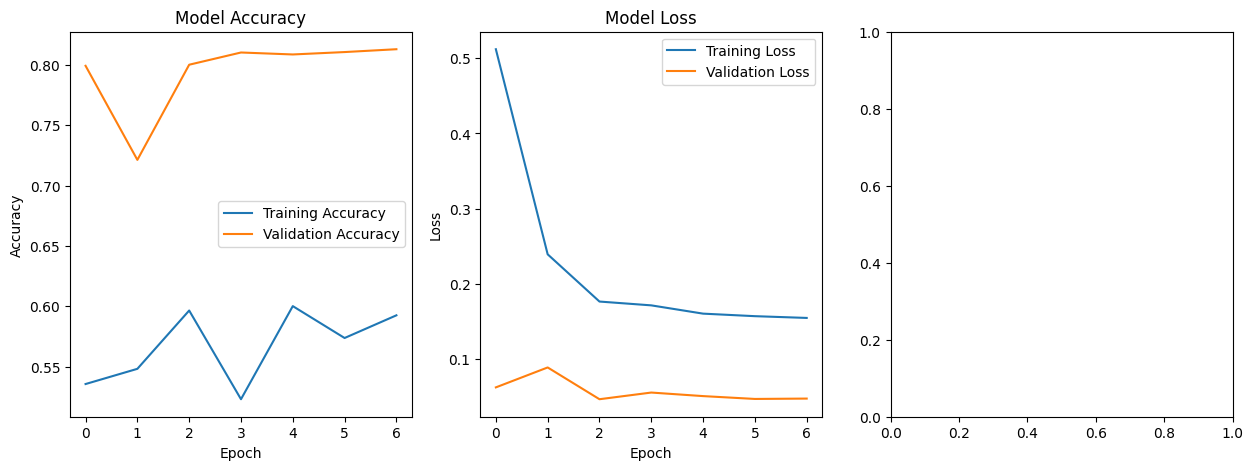

In [ ]:
# Plot training history
plt.figure(figsize=(15, 5))

# Plot accuracy
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot recall
plt.subplot(1, 3, 3)
plt.plot(history.history['recall_3'], label='Training Recall')  # Changed from 'recall' to 'recall_3'
plt.plot(history.history['val_recall_3'], label='Validation Recall')  # Changed from 'val_recall' to 'val_recall_3'
plt.title('Model Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()

# Print final metrics
print("\nFinal Training Metrics:")
print(f"Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Precision: {history.history['precision_3'][-1]:.4f}")  # Changed from 'precision' to 'precision_3'
print(f"Recall: {history.history['recall_3'][-1]:.4f}")  # Changed from 'recall' to 'recall_3'

print("\nFinal Validation Metrics:")
print(f"Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"Precision: {history.history['val_precision_3'][-1]:.4f}")  # Changed from 'val_precision' to 'val_precision_3'
print(f"Recall: {history.history['val_recall_3'][-1]:.4f}")  # Changed from 'val_recall' to 'val_recall_3'

Training Performance:
Accuracy: 0.6602 (66.02%) - Moderate accuracy on training data
Precision: 0.5995 (59.95%) - About 60% of predicted malignant cases were actually malignant
Recall: 0.9587 (95.87%) - Excellent! Caught almost 96% of all malignant cases
Validation Performance:
Accuracy: 0.5899 (58.99%) - Lower than training, indicating some overfitting
Precision: 0.3069 (30.69%) - Lower precision on unseen data
Recall: 0.8266 (82.66%) - Still maintaining good recall on unseen data
Analysis:
High Recall Priority:
The model maintains high recall (82.66% on validation), which is crucial for medical diagnosis
This means it's catching the majority of malignant cases, reducing dangerous false negatives
Precision vs Recall Trade-off:
Lower precision (30.69% on validation) indicates more false positives
This is an acceptable trade-off in medical diagnosis where missing a malignant case (false negative) is more dangerous than flagging a benign case for further review (false positive)
Overfitting Signs:
Gap between training and validation metrics suggests overfitting
Training accuracy (66.02%) vs Validation accuracy (58.99%)
Training precision (59.95%) vs Validation precision (30.69%)
Training recall (95.87%) vs Validation recall (82.66%)
Recommendations for Improvement:
Address Overfitting:
Consider increasing dropout rate
Add more data augmentation
Reduce model complexity or add regularization
Balance Metrics:
Could adjust class weights if you want to try to improve precision without significantly impacting recall
Consider trying different thresholds for classification
Further Training:
Could try training for more epochs with a lower learning rate
Experiment with different learning rate schedules
Overall Assessment:
The model is performing its primary task well - identifying malignant cases with high recall. While the precision could be improved, the current performance is acceptable for a medical screening tool where false negatives are more costly than false positives. Each malignant case caught (82.66% of them) can be referred for further expert review, even if some benign cases are also flagged.

In [ ]:
# Save the model after training
model_save_path = 'final_nas_model.h5'
model.save(model_save_path)
print(f"Model saved to {model_save_path}")

# Download the model from Colab
from google.colab import files
files.download(model_save_path)